In [1]:
from yolo3.utils import get_random_data
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import cv2 as cv

In [2]:
import os

In [3]:
%matplotlib inline

In [30]:
def rand(a=0,b=1):
    '''
    create a random value in (a,b]
    :param a: the left bound of the random value
    :param b: the right bound of the random value (not included)
    :return: a random value between (a,b]
    '''
    return np.random.rand()*(b-a)+a

def get_random_data(annotation_line, input_shape, random=True, max_boxes = 20, im_scale_l=0.2, im_scale_r=0.2,im_trans=0.2, hue=.1, sat=1.5, val=1.5,proc_img=True):
    
    line = annotation_line.split()
    image = Image.open(line[0])
    iw,ih = image.size
    h,w = input_shape
    boxes = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])
    
    if not random:
        # resize image
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2
        
        new_image = Image.new('RGB', (w,h), (128,128,128))
        image = image.resize((nw,nh), Image.BICUBIC)
        new_image.paste(image, (dx, dy))
        
        if proc_img:
            image_data = np.array(new_image)/255.
        else:
            image_data = np.array(new_image)


        # correct boxes
        boxes_data = np.zeros((max_boxes,5))
        if len(boxes)>0:
            np.random.shuffle(boxes)
            if len(boxes)>max_boxes: boxes = boxes[:max_boxes]
            boxes[:, [0,2]] = boxes[:, [0,2]]*scale + dx
            boxes[:, [1,3]] = boxes[:, [1,3]]*scale + dy
            boxes_data[:len(boxes)] = boxes

        return image_data, boxes_data
    
    scale = min(w/iw,h/ih)
    scale = rand(1-im_scale_l,1+im_scale_r)*scale
    nw,nh = int(iw*scale),int(ih*scale)
    image = image.resize((nw,nh),Image.BICUBIC)
    
    im_trans_x = rand(-im_trans,im_trans)
    im_trans_y = rand(-im_trans,im_trans)
    dx = int((w-nw)/2.0+im_trans_x*w) 
    dy = int((h-nh)/2.0+im_trans_y*h) 
    

    new_image = Image.new('RGB', (w,h), (128,128,128))
    new_image.paste(image,(dx,dy))
    
    image = new_image
    
    flipped = rand()<0.5
    if flipped: 
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # distort image
    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
    val = rand(1, val) if rand()<.5 else 1/rand(1, val)
    x = rgb_to_hsv(np.array(image)/255.)
    x[..., 0] += hue
    x[..., 0][x[..., 0]>1] -= 1
    x[..., 0][x[..., 0]<0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x>1] = 1
    x[x<0] = 0
    image_data = hsv_to_rgb(x)
    
    boxes_data = np.zeros((max_boxes,5))
    
    if len(boxes)>0:
        np.random.shuffle(boxes)
        boxes[:,[0,2]] = boxes[:,[0,2]]*nw/iw + dx
        boxes[:,[1,3]] = boxes[:,[1,3]]*nh/ih + dy
        if flipped: 
            print('flipped')
            boxes[:, [0,2]] = w - boxes[:, [2,0]]
        
        boxes_w_b = boxes[:, 2] - boxes[:, 0]
        boxes_h_b = boxes[:, 3] - boxes[:, 1]
        
        print(boxes)
        
        boxes[:,0] = np.minimum(np.maximum(boxes[:,0],0),w-1)
        boxes[:,1] = np.minimum(np.maximum(boxes[:,1],0),h-1)

        boxes[:,2] = np.minimum(np.maximum(boxes[:,2],0),w-1)
        boxes[:,3] = np.minimum(np.maximum(boxes[:,3],0),h-1)
        
        print(boxes)

        
        boxes_w_a = boxes[:, 2] - boxes[:, 0]
        boxes_h_a = boxes[:, 3] - boxes[:, 1]
        
        
        ratio = (boxes_w_a*boxes_h_a)/(boxes_w_b*boxes_h_b)
        boxes = boxes[ratio>0.40]
        print(boxes)
        
        if len(boxes)>max_boxes: boxes = boxes[:max_boxes]
        boxes_data[:len(boxes)] = boxes
        
    return image_data,boxes_data

In [31]:
with open('trainval.txt') as f:
    lines = f.readlines()


flipped
[[210 148 256 217   0]
 [-62 128  -4 197   0]
 [306  95 364 164   0]
 [ -2 154  45 223   0]
 [158 164 204 233   0]
 [260 125 306 194   0]
 [ 50 163  96 231   0]
 [103 169 149 238   0]]
[[210 148 256 217   0]
 [  0 128   0 197   0]
 [306  95 364 164   0]
 [  0 154  45 223   0]
 [158 164 204 233   0]
 [260 125 306 194   0]
 [ 50 163  96 231   0]
 [103 169 149 238   0]]
[[210 148 256 217   0]
 [306  95 364 164   0]
 [  0 154  45 223   0]
 [158 164 204 233   0]
 [260 125 306 194   0]
 [ 50 163  96 231   0]
 [103 169 149 238   0]]
(416, 416, 3)


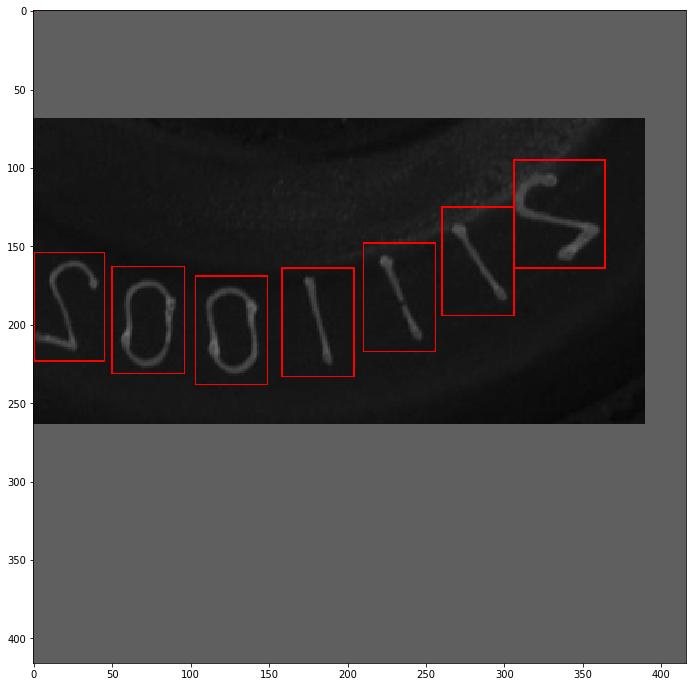

In [40]:
line = lines[0]
image,boxes = get_random_data(line,(416,416),random=True,proc_img=False)
image = np.array(image)
print(image.shape)
for box in boxes:
    x1,y1,x2,y2,_ = list(map(int,box))
    image = cv.rectangle(image,(x1,y1),(x2,y2),(255,0,0))
plt.figure(figsize=(12,12))
plt.imshow(image)

In [148]:
fps = []
for name in os.listdir('wheels'):
    fps.append(os.path.join('wheels',name))

0.020652619407527384 -0.06905659757966907
(416, 416, 3)


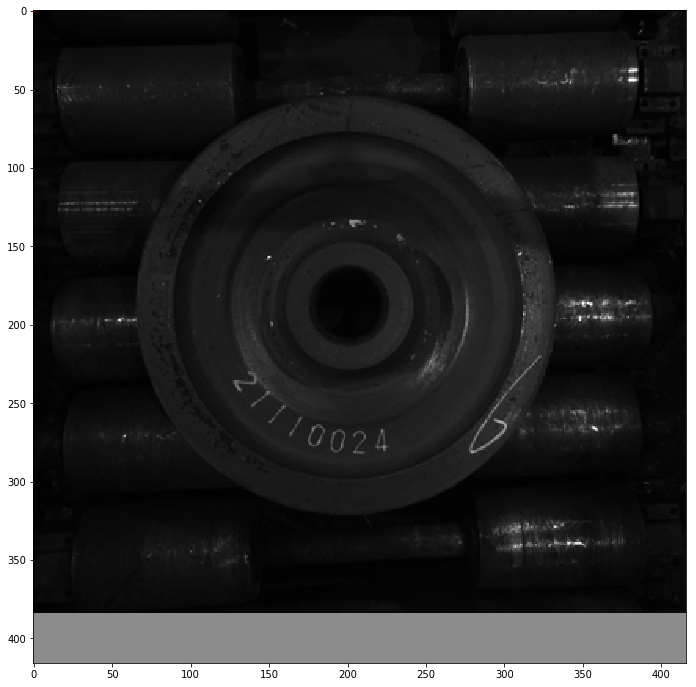

In [129]:
image,boxes = get_random_data(fps[0],(416,416),random=True,proc_img=False)
image = np.array(image)
print(image.shape)
for box in boxes:
    x1,y1,x2,y2,_ = list(map(int,box))
    image = cv.rectangle(image,(x1,y1),(x2,y2),(255,0,0))
plt.figure(figsize=(12,12))
plt.imshow(image)